In [ ]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, convolve
from lvl2_spectral import build_spectral_dataset, sig_wave_height

# November 10th

**Last week recap:**
Coding
- corrected data to use snsor 6 (seabird)
- processed sensor data into pandas dataframes

Figures
- cross shore water level gradients
- Compared significant wave heights (acorss all, IG, and SS bands) thru sensors 
- 

Learned
- my detiding is messed up and idk how to fix it. Putting it in the backburner for now. 

In [3]:
df1 = pd.read_parquet('data_interim/df1.parquet')
df6 = pd.read_parquet('data_interim/df6.parquet')

#### Compute spectra for each sensor into xarray ds, save as a .zarr

- made a function in lvl2_spectral.py that does exactly this

In [10]:
psd1 = build_spectral_dataset(df1, p = 'p' , h='h')
psd6 = build_spectral_dataset(df6, p = 'p' , h='h')


# save spectral dataset as an xarray using zarr
path = "./data_interim/spectra/S6_psd.zarr"

psd6.to_zarr(path, mode="w", consolidated=True)

/opt/anaconda3/envs/analysiz/lib/python3.12/site-packages/dask/array/reductions.py:1114: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/opt/anaconda3/envs/analysiz/lib/python3.12/site-packages/dask/array/reductions.py:1114: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/opt/anaconda3/envs/analysiz/lib/python3.12/site-packages/dask/array/reductions.py:1114: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/opt/anaconda3/envs/analysiz/lib/python3.12/site-packages/dask/array/reductions.py:1114: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)


#### recreate Hs plots but with sensor 6

In [ ]:
# open saved datasets, created with build_spectral_dataset function
ds1 = xr.open_zarr("./data_interim/spectra/S1_psd.zarr", consolidated=True)
ds6 = xr.open_zarr("./data_interim/spectra/S6_psd.zarr", consolidated=True)

##### Compute Hs

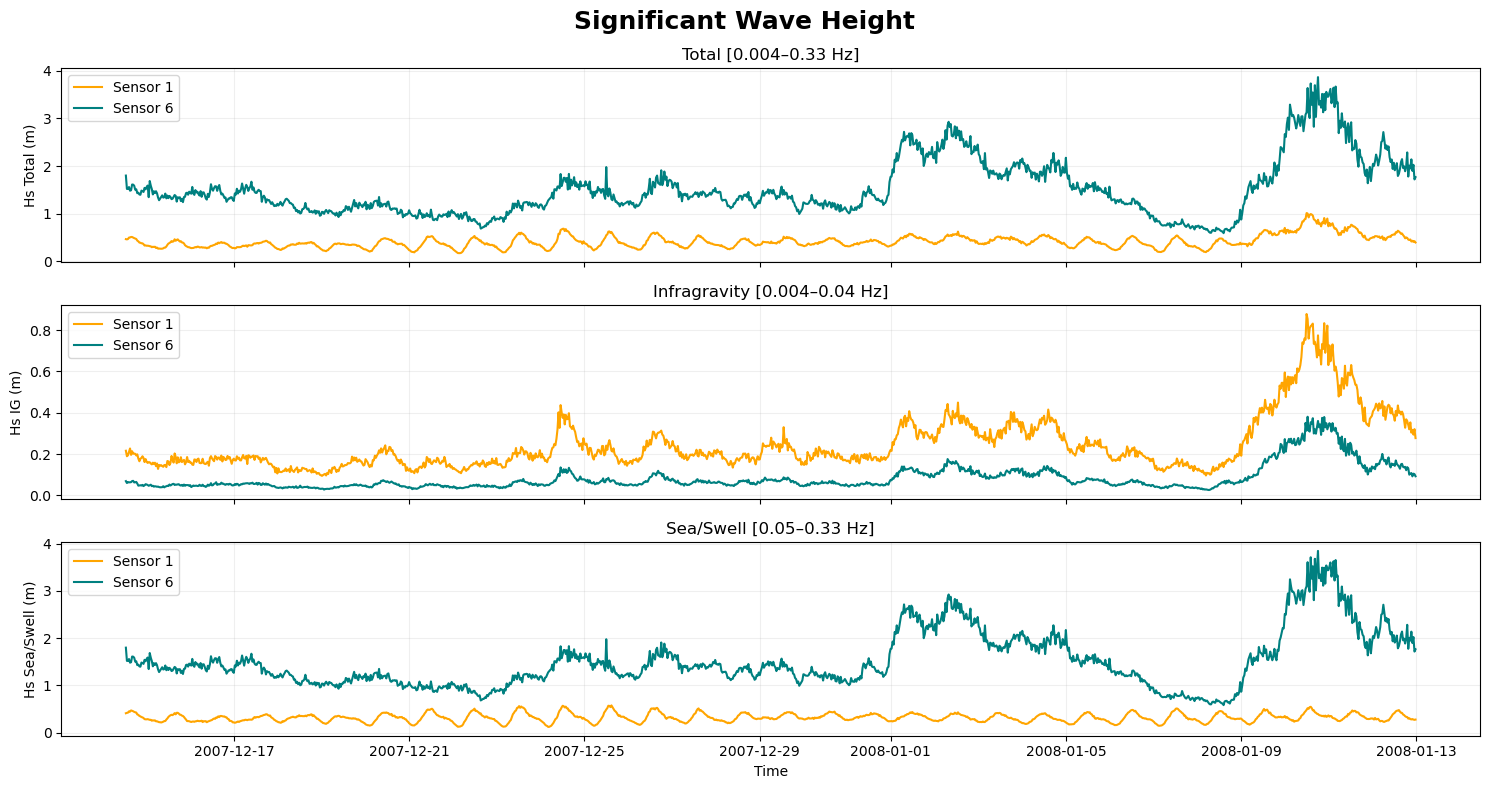

In [8]:
def Hs_band(ds, fmin=None, fmax=None):
    da = ds.Seta if (fmin is None and fmax is None) else ds.Seta.sel(freq=slice(fmin, fmax))
    m0 = da.integrate("freq")                 # ∫ S_eta df  -> (time,)
    return 4.0 * np.sqrt(m0) 

# time cutoff (exclude 1/13 and after)
TMAX = np.datetime64("2008-01-13")

# 1) slice datasets BEFORE 1/13
ds1_pre = ds1.where(ds1.time < TMAX, drop=True)
ds6_pre = ds6.where(ds6.time < TMAX, drop=True)

IG = (0.004, 0.04); SS = (0.05, 0.33); TOT = (0.004, 0.33)

Hs1_tot = Hs_band(ds1_pre, *TOT); Hs1_ig = Hs_band(ds1_pre, *IG); Hs1_ss = Hs_band(ds1_pre, *SS)
Hs6_tot = Hs_band(ds6_pre, *TOT); Hs6_ig = Hs_band(ds6_pre, *IG); Hs6_ss = Hs_band(ds6_pre, *SS)

# 3) align Sensor 6 to Sensor 1 times (nearest, half-hop tolerance)
dt_sec = np.median(np.diff(ds1_pre.time.values).astype("timedelta64[s]").astype(float))
tol = pd.Timedelta(seconds=float(dt_sec)/2 if dt_sec > 0 else 1200)

s1_tot = pd.Series(Hs1_tot.values, index=pd.to_datetime(Hs1_tot.time.values))
s1_ig  = pd.Series(Hs1_ig.values,  index=pd.to_datetime(Hs1_ig.time.values))
s1_ss  = pd.Series(Hs1_ss.values,  index=pd.to_datetime(Hs1_ss.time.values))

s6_tot = pd.Series(Hs6_tot.values, index=pd.to_datetime(Hs6_tot.time.values)).reindex(s1_tot.index, method="nearest", tolerance=tol)
s6_ig  = pd.Series(Hs6_ig.values,  index=pd.to_datetime(Hs6_ig.time.values)).reindex(s1_ig.index,   method="nearest", tolerance=tol)
s6_ss  = pd.Series(Hs6_ss.values,  index=pd.to_datetime(Hs6_ss.time.values)).reindex(s1_ss.index,   method="nearest", tolerance=tol)

mask = s6_tot.notna() & s6_ig.notna() & s6_ss.notna()
t_aligned   = s1_tot.index[mask]
Hs1_tot_aln = s1_tot[mask].values; Hs6_tot_aln = s6_tot[mask].values
Hs1_ig_aln  = s1_ig [mask].values; Hs6_ig_aln  = s6_ig [mask].values
Hs1_ss_aln  = s1_ss [mask].values; Hs6_ss_aln  = s6_ss [mask].values

# 4) plot (unchanged)
fig, axes = plt.subplots(3, 1, figsize=(15, 8), sharex=True)
fig.suptitle("Significant Wave Height", fontsize=18, weight="bold")

axes[0].plot(t_aligned, Hs1_tot_aln, label="Sensor 1", color="orange")
axes[0].plot(t_aligned, Hs6_tot_aln, label="Sensor 6", color="teal")
axes[0].set_ylabel("Hs Total (m)"); axes[0].set_title("Total [0.004–0.33 Hz]")
axes[0].grid(True, alpha=0.2); axes[0].legend(loc="upper left")

axes[1].plot(t_aligned, Hs1_ig_aln, label="Sensor 1", color="orange")
axes[1].plot(t_aligned, Hs6_ig_aln, label="Sensor 6", color="teal")
axes[1].set_ylabel("Hs IG (m)"); axes[1].set_title("Infragravity [0.004–0.04 Hz]")
axes[1].grid(True, alpha=0.2); axes[1].legend(loc="upper left")

axes[2].plot(t_aligned, Hs1_ss_aln, label="Sensor 1", color="orange")
axes[2].plot(t_aligned, Hs6_ss_aln, label="Sensor 6", color="teal")
axes[2].set_ylabel("Hs Sea/Swell (m)"); axes[2].set_title("Sea/Swell [0.05–0.33 Hz]")
axes[2].grid(True, alpha=0.2); axes[2].legend(loc="upper left")
axes[2].set_xlabel("Time")

plt.tight_layout(); plt.show()


#### Setup vs Hs

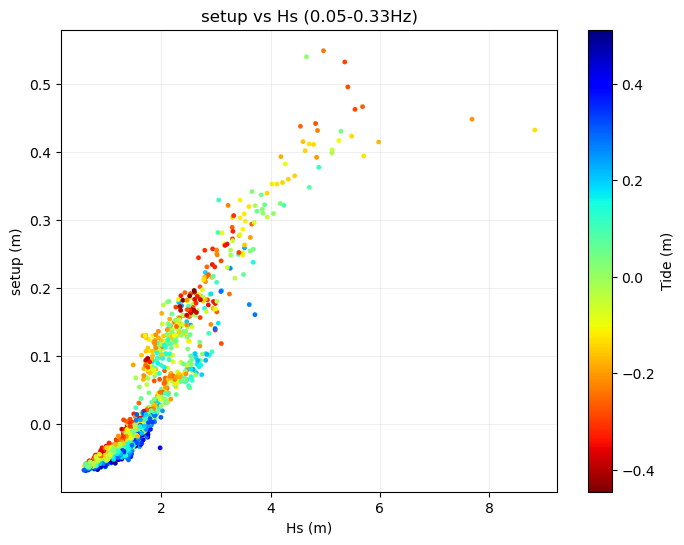

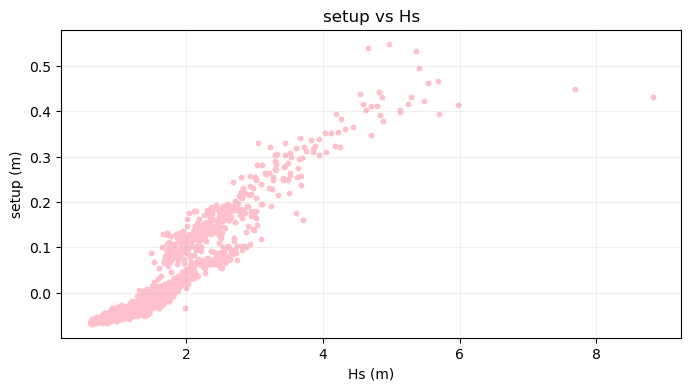

In [9]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# --- Hs from ds6 (offshore proxy), band-limited "total" ---
IG = (0.004, 0.04); SS = (0.05, 0.33); TOT = (0.004, 0.33)

# change band to whatever band you wants
band = SS

m0_6 = ds6.Seta.sel(freq=slice(*band)).integrate("freq")
Hs6  = (4.0*np.sqrt(m0_6)).rename("Hs")
Hs   = pd.Series(Hs6.values, index=pd.to_datetime(Hs6.time.values)).sort_index()

# --- 15-min means of water level (replace old h_15) ---
h1_15 = df1["h"].resample("15min").mean()
h6_15 = df6["h"].resample("15min").mean()

# demean and form cross-shore gradient n = (h1' - h6')
p1 = h1_15 - h1_15.mean()
p6 = h6_15 - h6_15.mean()
p1_aln, p6_aln = p1.align(p6, join="inner")
n  = pd.Series(p1_aln - p6_aln, index=pd.to_datetime(p6_aln.index)).sort_index()

# --- align n to Hs times (nearest, half-hop tolerance) ---
dt_sec = np.median(np.diff(ds6.time.values).astype("timedelta64[s]").astype(float))
tol = pd.Timedelta(seconds=float(dt_sec)/2 if dt_sec>0 else 1200)

pos  = n.index.get_indexer(Hs.index, method="nearest", tolerance=tol)
mask = pos != -1
Hs_aligned = Hs.iloc[mask]
n_aligned  = n.iloc[pos[mask]].set_axis(Hs_aligned.index)

# --- tide for coloring (fallback to h if no h_tide) ---
if "h_tide" in df6.columns:
    tide_raw = df6["h_tide"]
else:
    tide_raw = df6["h"]  # fallback
tide = pd.Series(tide_raw.values - tide_raw.mean(), index=pd.to_datetime(df6.index)).sort_index()
tide_at_spec = tide.reindex(Hs_aligned.index, method="nearest", tolerance=tol)
valid = tide_at_spec.notna()

Hs_plot   = Hs_aligned[valid]
n_plot    = n_aligned[valid]
tide_plot = tide_at_spec[valid]

# --- plots ---
fig, ax = plt.subplots(figsize=(8,6))
sc = ax.scatter(Hs_plot, n_plot, c=tide_plot, cmap="jet_r", edgecolor="none", s=12)
ax.set_xlabel("Hs (m)"); ax.set_ylabel("setup (m)"); ax.set_title("setup vs Hs (0.05-0.33Hz)"); ax.grid(True, alpha=0.2)
cbar = plt.colorbar(sc, ax=ax); cbar.set_label("Tide (m)")
plt.show()

fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(Hs_aligned, n_aligned, color="pink", s=10)
ax.set_xlabel("Hs (m)"); ax.set_ylabel("setup (m)"); ax.set_title("setup vs Hs"); ax.grid(True, alpha=0.2)
plt.show()


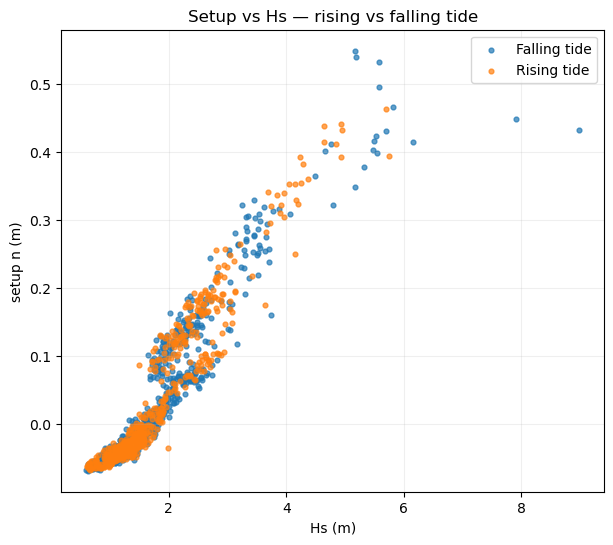

In [10]:
## rising vs falling tide

import numpy as np, pandas as pd, matplotlib.pyplot as plt

# --- Hs (sensor 6, total band) ---
TOT = (0.004, 0.33)
m0_6 = ds6.Seta.sel(freq=slice(*TOT)).integrate("freq")
Hs6  = (4.0*np.sqrt(m0_6)).rename("Hs")
Hs   = pd.Series(Hs6.values, index=pd.to_datetime(Hs6.time.values)).sort_index()

# --- setup proxy n from 15-min h means ---
h1_15 = df1["h"].resample("15min").mean()
h6_15 = df6["h"].resample("15min").mean()
p1 = h1_15 - h1_15.mean(); p6 = h6_15 - h6_15.mean()
p1a, p6a = p1.align(p6, join="inner")
n  = pd.Series(p1a - p6a, index=pd.to_datetime(p6a.index)).sort_index()

# --- align n to Hs times (nearest, half-hop tol) ---
dt_sec = np.median(np.diff(ds6.time.values).astype("timedelta64[s]").astype(float))
tol = pd.Timedelta(seconds=float(dt_sec)/2 if dt_sec>0 else 1200)
pos = n.index.get_indexer(Hs.index, method="nearest", tolerance=tol)
mask = pos != -1
Hs_aln = Hs.iloc[mask]
n_aln  = n.iloc[pos[mask]].set_axis(Hs_aln.index)

# --- rising vs falling tide (use 15-min tide trend) ---
tide15 = (df6["h_tide"] if "h_tide" in df6.columns else df6["h"]).resample("15min").mean()
tide_trend15 = tide15.diff()  # >0 rising, <0 falling
trend_at_spec = tide_trend15.reindex(Hs_aln.index, method="nearest", tolerance=tol)
is_rising = trend_at_spec > 0

# --- plot: rising vs falling ---
fig, ax = plt.subplots(figsize=(7,6))
ax.scatter(Hs_aln[~is_rising], n_aln[~is_rising], s=12, alpha=0.7, label="Falling tide")
ax.scatter(Hs_aln[ is_rising], n_aln[ is_rising], s=12, alpha=0.7, label="Rising tide")
ax.set_xlabel("Hs (m)"); ax.set_ylabel("setup n (m)")
ax.set_title("Setup vs Hs — rising vs falling tide")
ax.grid(True, alpha=0.2); ax.legend()
plt.show()


In [11]:
import numpy as np
from scipy.stats import linregress

# separate rising/falling subsets
Hs_rise, n_rise = Hs_aln[is_rising], n_aln[is_rising]
Hs_fall, n_fall = Hs_aln[~is_rising], n_aln[~is_rising]

m_rise, b_rise, _, _, _ = linregress(Hs_rise, n_rise)
m_fall, b_fall, _, _, _ = linregress(Hs_fall, n_fall)
print(f"Rising slope: {m_rise:.3f}, Falling slope: {m_fall:.3f}")


Rising slope: 0.124, Falling slope: 0.110


Meh, doesn't look like the rising/falling tide makes a difference on the time series    

#### Specific event discersion

starting out with plotting the autospectra of 3 interesting dates

/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_9650/3016389727.py:64: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, fmax)


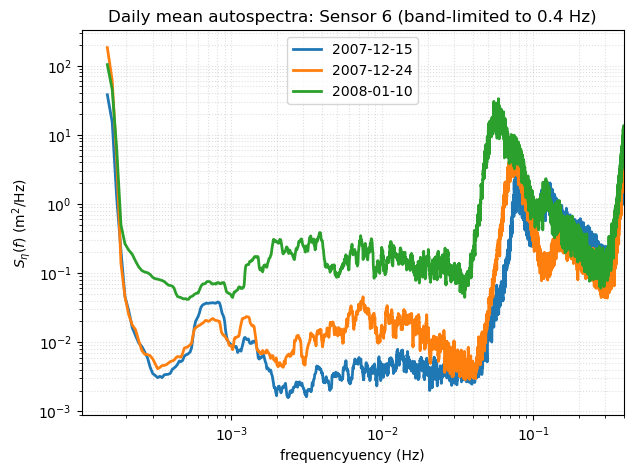

In [107]:
from BulkWaveStats import Spp_to_Seta
nperseg = 3600 * 24
noverlap = 0.5 * nperseg

## ----------------- Sensor 6 ------------- ##
yy = df6['p']
# get sampling rate from the index 
dt = np.median(np.diff(yy.index.view('int64'))) / 1e9  # seconds (int64 ns → s)
fs = 1.0 / dt
# take spectra or detided pressure
frequencys6, t_spec6, Spp6 = spectrogram(
    yy.values, 
    fs=fs, 
    window = 'hann',
    nperseg = nperseg,
    noverlap=noverlap,
    detrend='linear',
    scaling='density',
    mode='psd',
)
# Spp_to_Seta converts to surface elevation using transfer function from Falk's notes
Seta6, teta6, heta6 = Spp_to_Seta(Spp6, frequencys6, t_spec6, df6.index.values, df6['h'].values)
# collect variables into an xarray dataset
S6 = xr.Dataset(
    data_vars={
        "Seta": (("frequency", "time"), Seta6),
        "h_mean": (("time",), heta6),
    },
    coords={
        "frequency": xr.DataArray(frequencys6, dims="frequency", attrs={"units": "Hz"}),
        "time": xr.DataArray(teta6, dims="time", attrs={"long_name": "spectral time axis"}),
    },
    attrs={"source": "Spp_to_Seta output"},
)

# input dates/sensor dataset to analyze as well as frequencyuency bands 
ds = S6
dayA, dayB, dayC = "2007-12-15", "2007-12-24", '2008-01-10'
fmin, fmax = 0.0000001, 0.40   # band-limit to cut noise

def day_spectrum(ds, day, agg="mean"):
    sel = ds.sel(time=slice(f"{day}T00:00", f"{day}T23:59"))
    # daily mean (or median) autospectrum, band-limited
    S = sel.Seta.sel(frequency=slice(fmin, fmax))
    return (S.mean("time") if agg == "mean" else S.median("time"))

S_A = day_spectrum(ds, dayA, agg="mean")
S_B = day_spectrum(ds, dayB, agg="mean")
S_C = day_spectrum(ds, dayC, agg="mean")


# optional light smoothing in frequencyuency (comment out if not needed)
S_A = S_A.rolling(frequency=25, center=True).mean()
S_B = S_B.rolling(frequency=25, center=True).mean()
S_C = S_C.rolling(frequency=25, center=True).mean()


fig, ax = plt.subplots(figsize=(7,5))
ax.loglog(S_A.frequency, S_A, label=dayA, lw=2)
ax.loglog(S_B.frequency, S_B, label=dayB, lw=2)
ax.loglog(S_C.frequency, S_C, label=dayC, lw=2)


ax.set_xlim(0, fmax)
ax.set_xlabel("frequencyuency (Hz)")
ax.set_ylabel(r"$S_{\eta}(f)$ (m$^2$/Hz)")
ax.set_title(f"Daily mean autospectra: Sensor 6 (band-limited to {fmax} Hz)")
ax.grid(True, which="both", ls=":", alpha=0.4)
ax.legend()
plt.show()



##### Take fourier transform of 18.2 hr window (to resolve low frequency hooblah)

In [ ]:
from BulkWaveStats import Spp_to_Seta
from scipy.signal import spectrogram

# spectral inputs
nperseg = 12 * 3600
noverlap = int(0.5 * nperseg) # 50% overlap

## -------- Sensor 1 ------- ##
xx = df1['p']
# get sampling rate from the index 
dt = np.median(np.diff(xx.index.view('int64'))) / 1e9  # seconds (int64 ns → s)
fs = 1.0 / dt
# take spectra or detided pressure
freqs1, t_spec1, Spp1 = spectrogram(
    xx.values, 
    fs=fs, 
    window = 'hann',
    nperseg = nperseg,
    noverlap=noverlap,
    detrend='linear',
    scaling='density',
    mode='psd',
)
# Spp_to_Seta converts to surface elevation using transfer function from Falk's notes
Seta1, teta1, heta1 = Spp_to_Seta(Spp1, freqs1, t_spec1, df1.index.values, df1['h'].values)
# collect variables into an xarray dataset
psd1 = xr.Dataset(
    data_vars={
        "Seta": (("frequency", "time"), Seta1),
        "h_mean": (("time",), heta1),
    },
    coords={
        "frequency": xr.DataArray(freqs1, dims="frequency", attrs={"units": "Hz"}),
        "time": xr.DataArray(teta1, dims="time", attrs={"long_name": "spectral time axis"}),
    },
    attrs={"source": "Spp_to_Seta output"},
)

## ----------------- Sensor 6 ------------- ##
yy = df6['p']
# get sampling rate from the index 
dt = np.median(np.diff(yy.index.view('int64'))) / 1e9  # seconds (int64 ns → s)
fs = 1.0 / dt
# take spectra or detided pressure
freqs6, t_spec6, Spp6 = spectrogram(
    yy.values, 
    fs=fs, 
    window = 'hann',
    nperseg = nperseg,
    noverlap=noverlap,
    detrend='linear',
    scaling='density',
    mode='psd',
)
# Spp_to_Seta converts to surface elevation using transfer function from Falk's notes
Seta6, teta6, heta6 = Spp_to_Seta(Spp6, freqs6, t_spec6, df6.index.values, df6['h'].values)
# collect variables into an xarray dataset
S6 = xr.Dataset(
    data_vars={
        "Seta": (("frequency", "time"), Seta6),
        "h_mean": (("time",), heta6),
    },
    coords={
        "frequency": xr.DataArray(freqs6, dims="frequency", attrs={"units": "Hz"}),
        "time": xr.DataArray(teta6, dims="time", attrs={"long_name": "spectral time axis"}),
    },
    attrs={"source": "Spp_to_Seta output"},
)

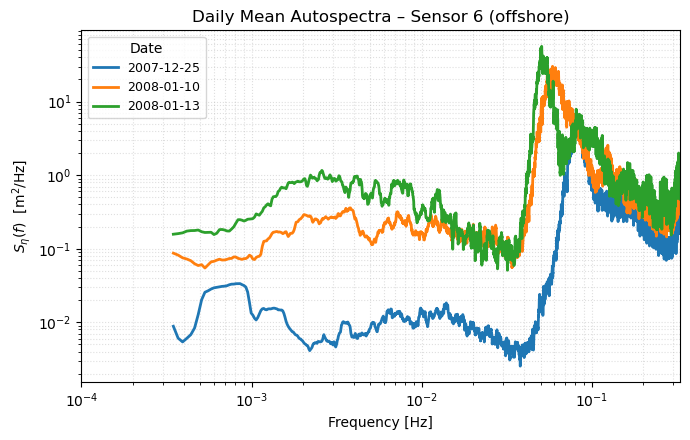

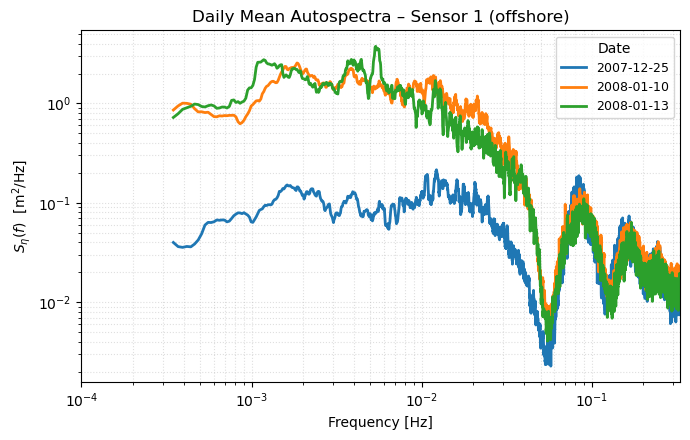

In [30]:
import matplotlib.pyplot as plt

# --- days of interest ---
days = ["2007-12-25", "2008-01-10", "2008-01-13"]

# --- frequency limits ---
fmin, fmax = 0.0001, 0.33

plt.figure(figsize=(7,4.5))

for day in days:
    sel = S6.sel(time=slice(f"{day}T00:00", f"{day}T23:59"), frequency=slice(fmin, fmax))
    S_day = sel.Seta.mean("time")
    S_day_smooth = S_day.rolling(frequency=20, center=True).mean()
    plt.loglog(sel.frequency, S_day_smooth, lw=2, label=day)

plt.xlabel("Frequency [Hz]")
plt.ylabel(r"$S_{\eta}(f)$  [m$^2$/Hz]")
plt.title("Daily Mean Autospectra – Sensor 6 (offshore)")
plt.xlim(fmin, fmax)
plt.grid(True, which="both", ls=":", alpha=0.4)
plt.legend(title="Date", fontsize=9)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4.5))

for day in days:
    sel = psd1.sel(time=slice(f"{day}T00:00", f"{day}T23:59"), frequency=slice(fmin, fmax))
    S_day = sel.Seta.mean("time")
    S_day_smooth = S_day.rolling(frequency=20, center=True).mean()
    plt.loglog(sel.frequency, S_day_smooth, lw=2, label=day)

plt.xlabel("Frequency [Hz]")
plt.ylabel(r"$S_{\eta}(f)$  [m$^2$/Hz]")
plt.title("Daily Mean Autospectra – Sensor 1 (offshore)")
plt.xlim(fmin, fmax)
plt.grid(True, which="both", ls=":", alpha=0.4)
plt.legend(title="Date", fontsize=9)
plt.tight_layout()
plt.show()


looking at the big picture, 12-25 wasn't a crazy swell event but had relatively large IG energy compared to Hs. 01-10 showed similar signal while 01-13 was generally a large swell event with corresponding large IG energy

Noticing this low frequency hump on 12-25. Could it be bound IG from surf beat?

Im unsure, something i'd like to talke to MM about. 

**Moving On**
want to look at cospectra to see if more interesting signals pop out. 

#### Cospectra analysis

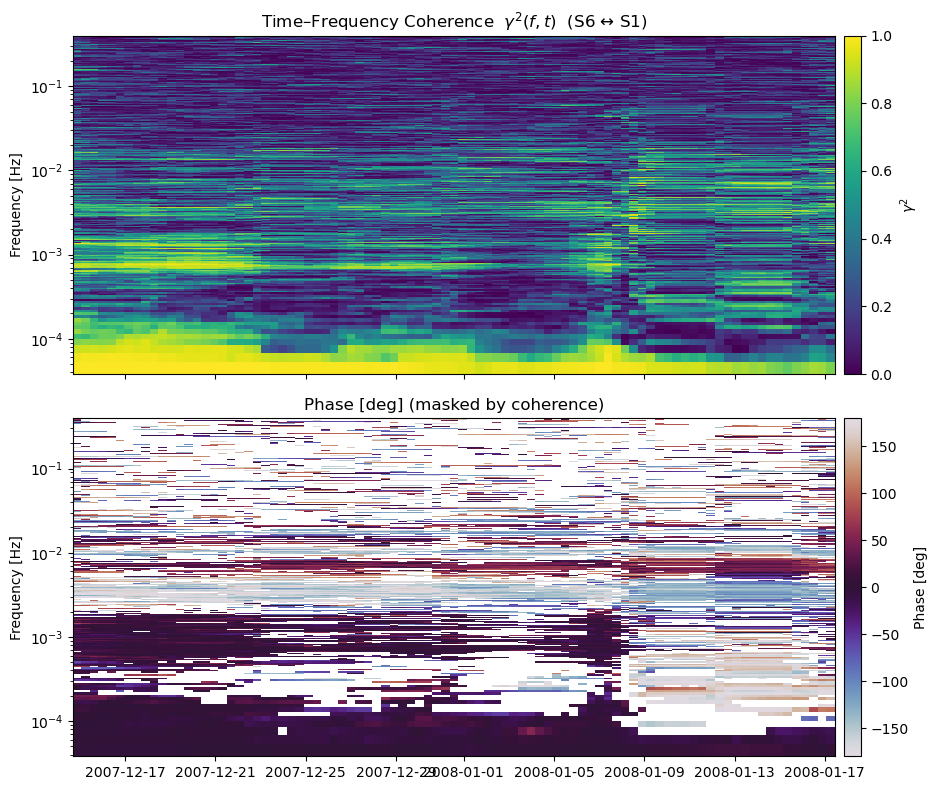

In [77]:
## ------- Coherence thru time series --------- ##


# ------------------- params -------------------
# STFT parameters (same style you've been using)
nperseg = 65536
noverlap = nperseg // 2
window   = 'hann'
detrend  = 'linear'
scaling  = 'density'
# display band
fmin, fmax = 0.00004, 0.40          # show IG up through swell
# time-smoothing across adjacent STFT windows (improves DoF for γ²)
tsmooth = 9                        # odd integer (e.g., 5, 9, 13)
coh_mask = 0.2                     # hide phase where coherence < this

# ------------------- align data -------------------
x = df6['p'].dropna()              # offshore
y = df1['p'].dropna()              # nearshore
x, y = x.align(y, join='inner')
fs = 1.0 / (np.median(np.diff(x.index.view('int64'))) / 1e9)

# ------------------- complex spectrograms -------------------
# mode='complex' gives STFT coefficients X(f,t), Y(f,t)
f, tsec, X = spectrogram(
    x.values, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap,
    detrend=detrend, scaling=scaling, mode='complex'
)
_, _, Y = spectrogram(
    y.values, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap,
    detrend=detrend, scaling=scaling, mode='complex'
)

# convert spectrogram time centers to datetimes
t0 = x.index[0]
t = pd.to_datetime(t0) + pd.to_timedelta(tsec, unit='s')

# band-limit
band = (f >= fmin) & (f <= fmax)
f = f[band]
X = X[band, :]
Y = Y[band, :]

# ------------------- cross-spectral quantities (time-resolved) -------------------
Sxx = np.abs(X)**2
Syy = np.abs(Y)**2
Sxy = X * np.conj(Y)               # complex cross-spectrum

# smooth along time to stabilize estimates (<> operator over t)
ker = np.ones((1, tsmooth), dtype=float) / tsmooth
Sxx_s = convolve(Sxx, ker, mode='same')
Syy_s = convolve(Syy, ker, mode='same')
Sxy_s = convolve(Sxy, ker, mode='same')

# coherence and phase as functions of (f, t)
coh_ft = (np.abs(Sxy_s)**2) / (Sxx_s * Syy_s)   # ∈ [0,1]
phase_ft = np.angle(Sxy_s)                      # radians

# mask phase where coherence is weak
phase_masked = np.where(coh_ft >= coh_mask, np.degrees(phase_ft), np.nan)

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(10, 8), sharex=True,
    gridspec_kw={"height_ratios": [2, 2]}  # make tide shorter
)

# ---- top: coherence ----
im1 = ax1.pcolormesh(t, f, coh_ft, shading="auto", vmin=0, vmax=1, cmap="viridis")
ax1.set_yscale("log")
ax1.set_ylabel("Frequency [Hz]")
ax1.set_title(r"Time–Frequency Coherence  $\gamma^2(f,t)$  (S6 ↔ S1)")
fig.colorbar(im1, ax=ax1, label=r"$\gamma^2$", pad=0.01)

# ---- middle: phase ----
im2 = ax2.pcolormesh(t, f, phase_masked, shading="auto", vmin=-180, vmax=180, cmap="twilight")
ax2.set_yscale("log")
ax2.set_ylabel("Frequency [Hz]")
ax2.set_title("Phase [deg] (masked by coherence)")
fig.colorbar(im2, ax=ax2, label="Phase [deg]", pad=0.01)

plt.tight_layout()
plt.show()



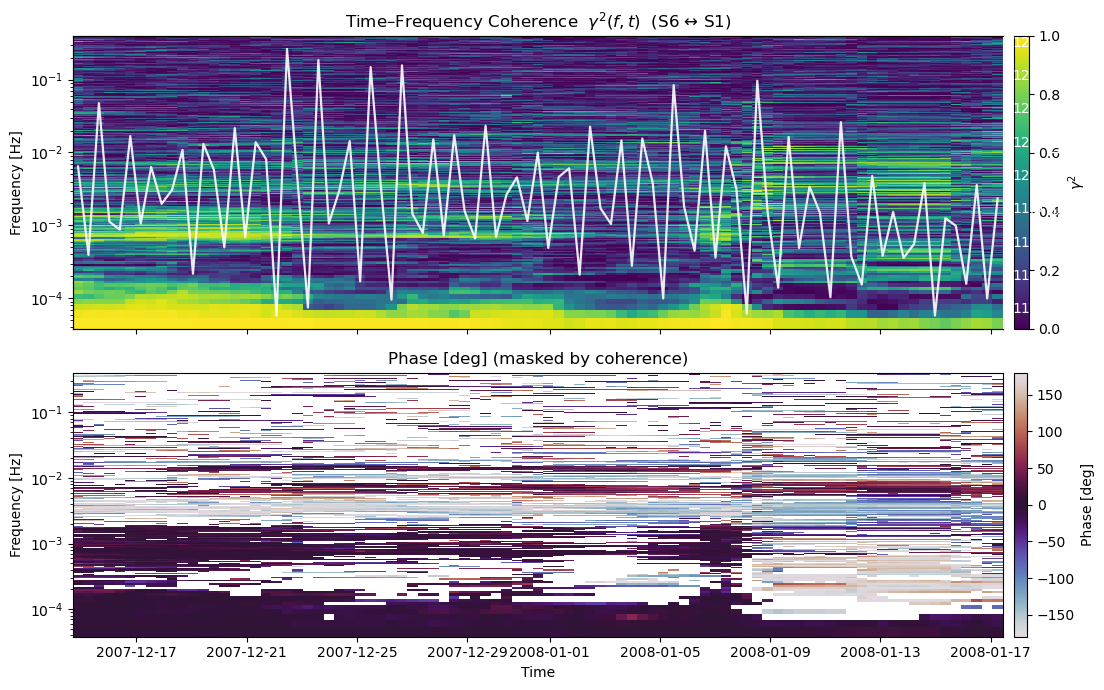

In [78]:
# --- overlay tide (meters) on the coherence panel using a second y-axis ---
import matplotlib.pyplot as plt
import pandas as pd

# tide time series aligned to spectrogram times
tide_line = df6["h_tide"].reindex(t, method="nearest")

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(12, 7), sharex=True,
    gridspec_kw={"height_ratios": [2.0, 1.8]}
)

# ---- TOP: coherence heatmap (time–frequency) ----
im1 = ax1.pcolormesh(t, f, coh_ft, shading="auto", vmin=0, vmax=1, cmap="viridis")
ax1.set_yscale("log")
ax1.set_ylabel("Frequency [Hz]")
ax1.set_title(r"Time–Frequency Coherence  $\gamma^2(f,t)$  (S6 ↔ S1)")
cbar1 = fig.colorbar(im1, ax=ax1, label=r"$\gamma^2$", pad=0.01)

# add a second y-axis for tide (meters), overlaid on the same panel
ax1_tide = ax1.twinx()
ax1_tide.plot(t, tide_line, color="w", lw=1.6, alpha=0.9, label="Tide height")
ax1_tide.set_ylabel("Tide height [m]")
ax1_tide.grid(False)
# optional: make the right spine light so it’s readable over the heatmap
ax1_tide.spines['right'].set_color('white')
ax1_tide.yaxis.label.set_color('white')
ax1_tide.tick_params(axis='y', colors='white')

# ---- BOTTOM: phase heatmap (masked by coherence) ----
im2 = ax2.pcolormesh(t, f, phase_masked, shading="auto",
                     vmin=-180, vmax=180, cmap="twilight")
ax2.set_yscale("log")
ax2.set_ylabel("Frequency [Hz]")
ax2.set_xlabel("Time")
ax2.set_title("Phase [deg] (masked by coherence)")
cbar2 = fig.colorbar(im2, ax=ax2, label="Phase [deg]", pad=0.01)

plt.tight_layout()
plt.show()


ok not my clearest figure in the world. I wonder if instead of tide i plot *tide range*  to see if there were exteme highs/lows that day 

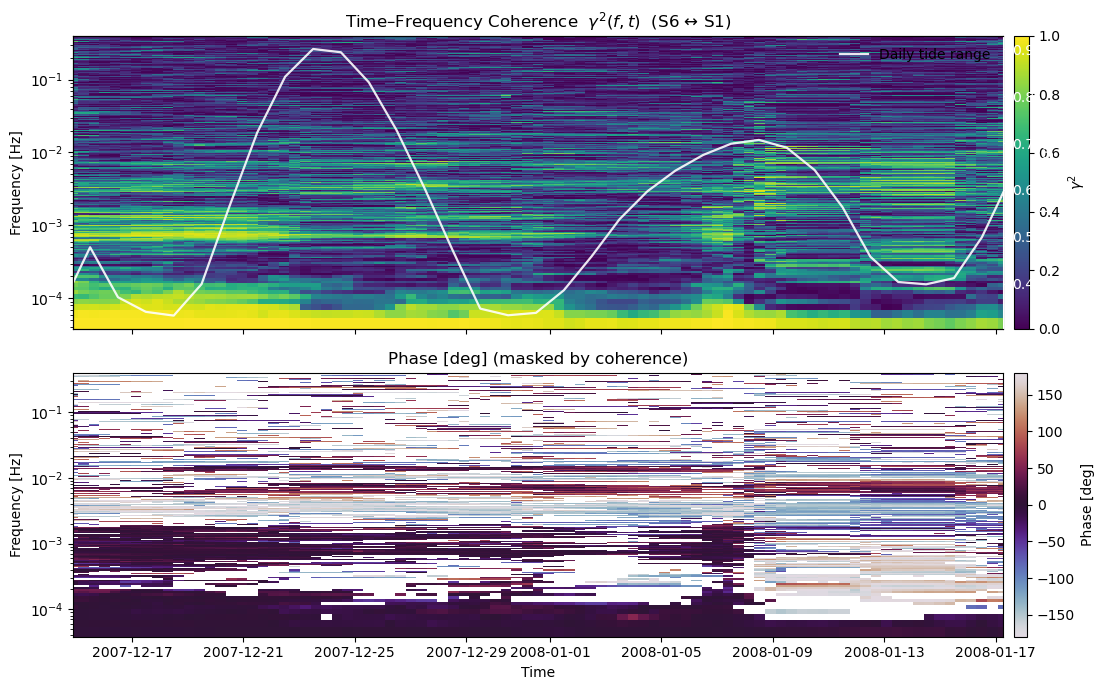

In [80]:
# --- DAILY TIDE RANGE SERIES ---
# use the full-resolution tide; no normalization
tide_full = df6["h_tide"].dropna()

# daily min, max, and range
daily_stats = tide_full.resample("D").agg(["min", "max"])
daily_stats["range"] = daily_stats["max"] - daily_stats["min"]

# plot time at midday so each day's point sits in the center of its day
t_daily = daily_stats.index + pd.Timedelta(hours=12)
range_daily = daily_stats["range"]

# OPTIONAL: lightly smooth the daily range (comment out if not desired)
#range_smooth = range_daily.rolling(3, center=True).mean()

# --- plot (coherence + phase) ---
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(12, 7), sharex=True,
    gridspec_kw={"height_ratios": [2.0, 1.8]}
)

# TOP: coherence heatmap
im1 = ax1.pcolormesh(t, f, coh_ft, shading="auto", vmin=0, vmax=1, cmap="viridis")
ax1.set_yscale("log")
ax1.set_ylabel("Frequency [Hz]")
ax1.set_title(r"Time–Frequency Coherence  $\gamma^2(f,t)$  (S6 ↔ S1)")
fig.colorbar(im1, ax=ax1, label=r"$\gamma^2$", pad=0.01)

# ---- overlay DAILY TIDE RANGE on a twin right y-axis (meters) ----
ax1_range = ax1.twinx()
ax1_range.plot(t_daily, range_daily, color="w", lw=1.6, alpha=0.9, label="Daily tide range")
# optional smoother line on top
# ax1_range.plot(t_daily, range_smooth, color="w", lw=2.6, alpha=0.5)
ax1_range.set_ylabel("Daily tide range [m]")
ax1_range.grid(False)
# make the right axis readable over the heatmap
ax1_range.spines["right"].set_color("white")
ax1_range.yaxis.label.set_color("white")
ax1_range.tick_params(axis="y", colors="white")
ax1_range.legend(loc="upper right", frameon=False)

# BOTTOM: phase heatmap
im2 = ax2.pcolormesh(t, f, phase_masked, shading="auto", vmin=-180, vmax=180, cmap="twilight")
ax2.set_yscale("log")
ax2.set_ylabel("Frequency [Hz]")
ax2.set_xlabel("Time")
ax2.set_title("Phase [deg] (masked by coherence)")
fig.colorbar(im2, ax=ax2, label="Phase [deg]", pad=0.01)

# keep x-limits consistent across both panels
for ax in (ax1, ax2, ax1_range):
    ax.set_xlim(pd.to_datetime(t[0]), pd.to_datetime(t[-1]))

plt.tight_layout()
plt.show()


In [83]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

def cross_spectral_day(df1, df6, date, var="p",
                       fmin=0.0004, fmax=0.4,
                       nperseg=16384, noverlap=None,
                       smooth_N=21):
    """
    Compute cross-spectral analysis between two sensors for a given day.

    Parameters
    ----------
    df1, df6 : pd.DataFrame
        DataFrames containing time-indexed pressure (or other) series.
    date : str
        Date string, e.g. '2008-01-10'
    var : str, default 'p'
        Column name for pressure variable to analyze.
    fmin, fmax : float
        Frequency limits for display.
    nperseg : int
        Segment length for FFT window.
    noverlap : int or None
        Segment overlap (defaults to 50% if None).
    smooth_N : int
        Number of frequency bins for rolling mean smoothing.

    Returns
    -------
    fig : matplotlib.figure.Figure
        4-panel figure of co-spectrum, coherence, phase, and time lag.
    """

    import pandas as pd
    from scipy.signal import get_window

    # --- PARAMETERS ---
    if noverlap is None:
        noverlap = nperseg // 2

    window = "hann"
    detrend = "linear"
    scaling = "density"

    # --- SLICE DATA FOR SPECIFIED DAY ---
    start = pd.Timestamp(date)
    end = start + pd.Timedelta(days=1)

    x = df6[var].loc[start:end].dropna()
    y = df1[var].loc[start:end].dropna()

    if len(x) == 0 or len(y) == 0:
        print(f"No data available for {date}")
        return None

    # Align time
    x, y = x.align(y, join="inner")

    # --- SAMPLING FREQUENCY ---
    dt = np.median(np.diff(x.index.view("int64"))) / 1e9
    fs = 1.0 / dt

    # --- COMPUTE SPECTROGRAMS (complex) ---
    f, t, X = spectrogram(
        x.values, fs=fs, window=window, nperseg=nperseg,
        noverlap=noverlap, detrend=detrend, scaling=scaling,
        mode="complex"
    )
    _, _, Y = spectrogram(
        y.values, fs=fs, window=window, nperseg=nperseg,
        noverlap=noverlap, detrend=detrend, scaling=scaling,
        mode="complex"
    )

    # --- AUTO & CROSS SPECTRA ---
    Sxx = np.abs(X) ** 2
    Syy = np.abs(Y) ** 2
    Sxy = X * np.conj(Y)

    Sxx_mean = np.mean(Sxx, axis=1)
    Syy_mean = np.mean(Syy, axis=1)
    Sxy_mean = np.mean(Sxy, axis=1)

    # --- BAND LIMITS ---
    sel = (f >= fmin) & (f <= fmax)
    f = f[sel]
    Sxx_mean, Syy_mean, Sxy_mean = Sxx_mean[sel], Syy_mean[sel], Sxy_mean[sel]

    # --- CROSS-SPECTRAL QUANTITIES ---
    Cxy = np.real(Sxy_mean)
    coherence = (np.abs(Sxy_mean) ** 2) / (Sxx_mean * Syy_mean)
    phase = np.angle(Sxy_mean)
    tau = phase / (2 * np.pi * f)

    # --- SMOOTHING ---
    def smooth(y, N):
        return np.convolve(y, np.ones(N) / N, mode="same")

    Cxy_s = smooth(Cxy, smooth_N)
    coh_s = smooth(coherence, smooth_N)
    phase_s = smooth(phase, smooth_N)
    tau_s = smooth(tau, smooth_N)

    # --- PLOTS ---
    fig, axs = plt.subplots(4, 1, figsize=(8, 9), sharex=True)
    fig.suptitle(f"Cross-spectral analysis — S6 ↔ S1 ({var})  |  {date}")

    labels = [
        ("Co-spectrum  $C_{xy}$ [Pa² s]", Cxy_s, "C0"),
        (r"Coherence  $\gamma^2$", coh_s, "C2"),
        ("Phase [deg]", np.degrees(phase_s), "C1"),
        ("Lag [s]", tau_s, "C3"),
    ]

    for ax, (ylabel, data, col) in zip(axs, labels):
        ax.semilogx(f, data, color=col, lw=1.3)
        ax.axvspan(0.004, 0.04, color="gray", alpha=0.15)  # IG band
        ax.axvspan(0.05, 0.33, color="C1", alpha=0.10)    # swell band
        ax.grid(True, which="both", ls=":", alpha=0.4)
        ax.set_ylabel(ylabel)

    axs[0].axhline(0, color='k', lw=0.7)
    axs[1].set_ylim(0, 1.05)
    axs[-1].set_xlabel("Frequency [Hz]")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    return fig


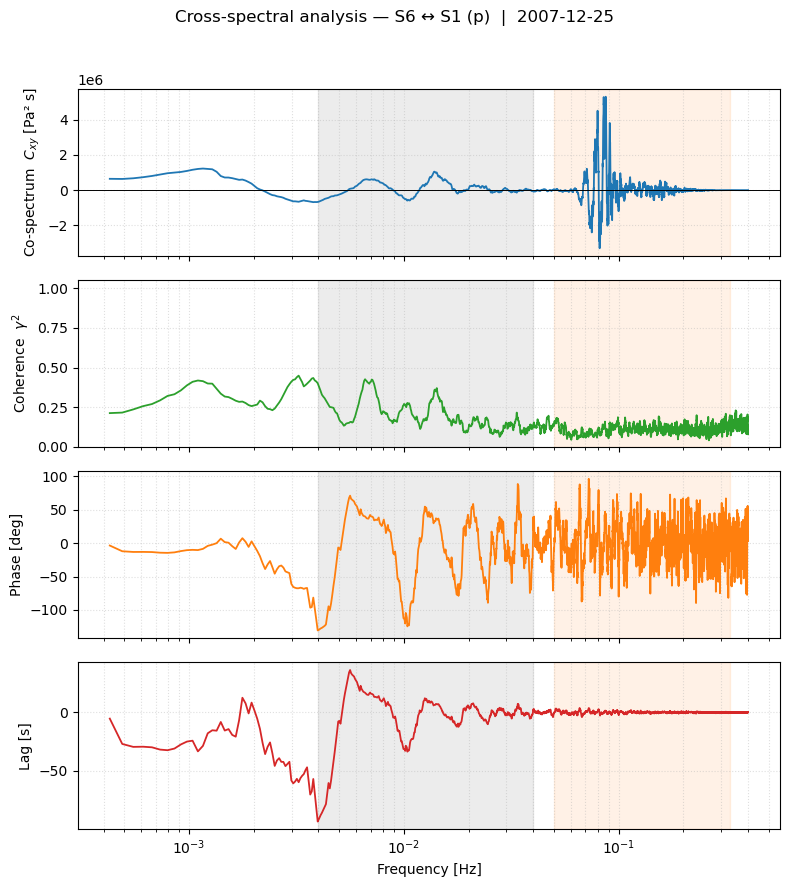

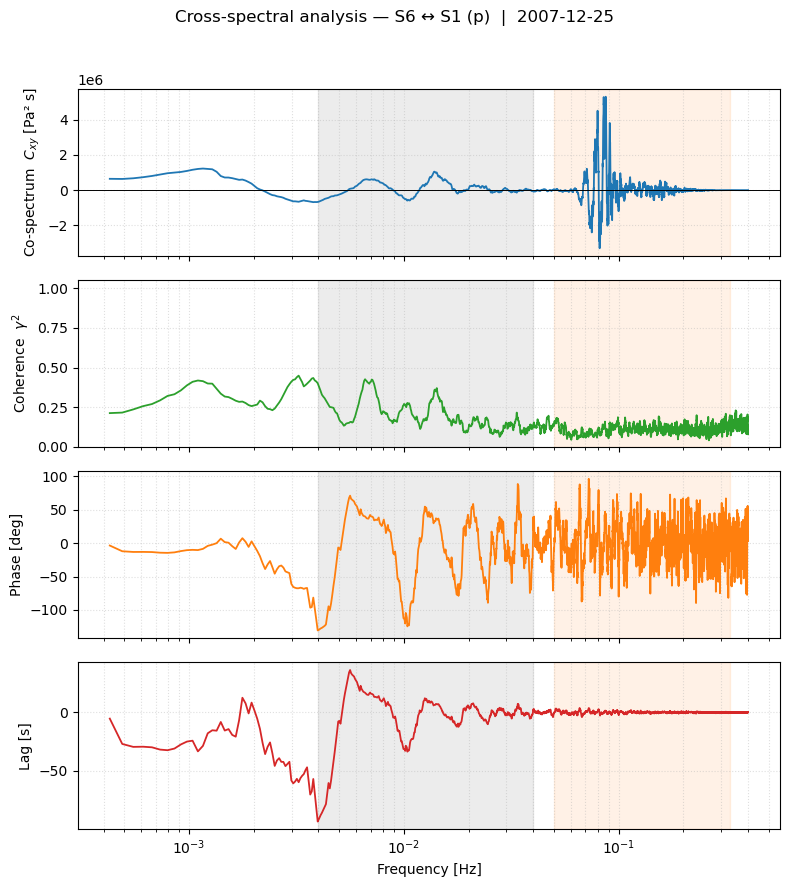

In [85]:
cross_spectral_day(df1, df6, date='2007-12-25', var='p')

## post meeting with mark 

the low frequency hump on 12-25's autopectra is interesting, specifically because it shows up offshore and not at the nearshore. 

This suggests that it could be a sign of the envelope. In order to prove that, MM suggested complex demodulation. As I understand it, this is picking out an IG bandpass using a butterworth filter and transforming it back to the time domain. Then, compare this time series with the swell to see if it matches the envelope of the wave groups. 

Also, pequignet's paper has s____ citation which shows some method of figuring out whether a wave is incident or reflective using pressure sensors and adcp's.  

Start reading on bimodal spectras and what that means. Actually, just read thomson and emery until your eyes bleed and can explain everything in chapter 5.

#### Comparing 12-25 hump to other small swell days

In [117]:
from scipy.signal import butter, filtfilt, hilbert, welch, coherence

# parameters 
fs = 1.0  # Hz
date = "2007-12-25"

# subset day
day6 = df6.loc[date]
p = day6["p"].values.astype(float)

# remove mean & linear trend (helps a lot for Hilbert & bandpass)
t = np.arange(len(p)) / fs
p_detr = p - np.polyval(np.polyfit(t, p, 1), t)

# frequency band
fmin, fmax = 0.07, 0.14 

# butterworth filter normalized to Nyquist
b,a = butter(4, [fmin/(fs/2), fmax/(fs/2)], btype='band')
x_filt = filtfilt(b,a,df6['p'].values)

# hilbert transform 
analytic = hilbert(x_filt)
A = np.abs(analytic)   # envelope time series
A_detr = A - np.mean(A)

In [118]:
# IG band 
fmin_ig, fmax_ig = 0.004, 0.04   # ~250–25 s periods; adjust if needed

wn_ig = [fmin_ig/(fs/2), fmax_ig/(fs/2)]
b_ig, a_ig = butter(4, wn_ig, btype="band")

p_ig = filtfilt(b_ig, a_ig, p_detr)


/opt/anaconda3/envs/analysiz/lib/python3.12/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 86400 is greater than input length  = 86360, using nperseg = 86360
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


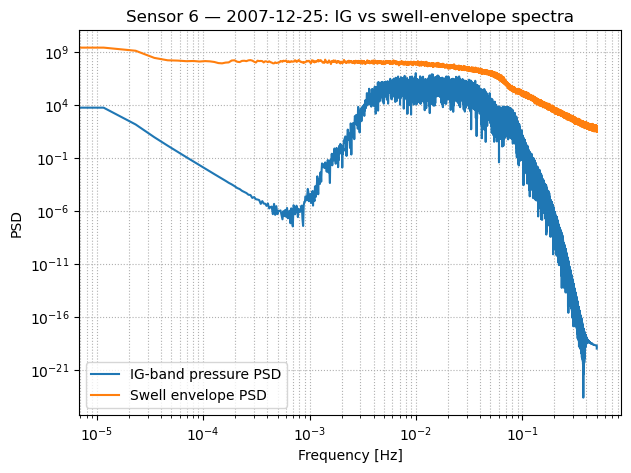

In [119]:
nperseg = 3600 * 24  

f_A, S_A = welch(A_detr, fs=fs, nperseg=nperseg, detrend='linear')
f_ig, S_ig = welch(p_ig,      fs=fs, nperseg=nperseg, detrend='linear')

plt.figure(figsize=(7,5))
plt.loglog(f_ig, S_ig, label="IG-band pressure PSD")
plt.loglog(f_A,  S_A,  label="Swell envelope PSD")
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.title("Sensor 6 — 2007-12-25: IG vs swell-envelope spectra")
plt.show()


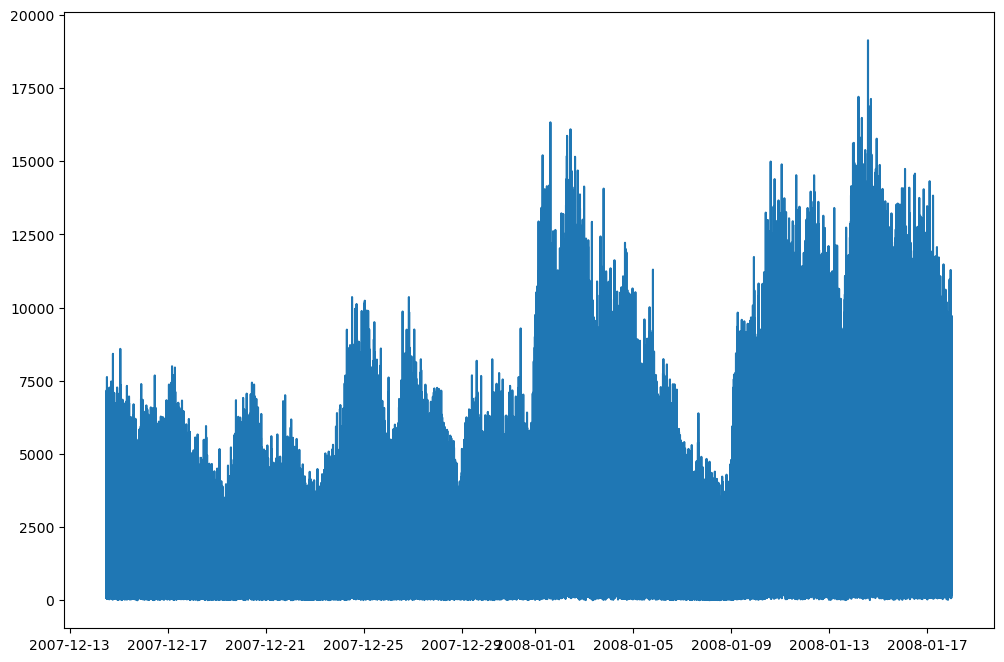

In [114]:
plt.subplots(figsize=(12,8))
plt.plot(df6.index, A)

In [133]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

MATLAB_EPOCH_OFFSET = 719529.0
SECONDS_PER_DAY = 86400.0

def matlab_datenum_to_datetime64(tnums):
    tnums = np.asarray(tnums, dtype=np.float64)
    delta_days = tnums - MATLAB_EPOCH_OFFSET
    ns_since_unix = np.round(delta_days * SECONDS_PER_DAY * 1e9).astype("int64")
    return np.datetime64("1970-01-01") + ns_since_unix.astype("timedelta64[ns]")

mat = sio.loadmat("data_raw/MoA68411.mat")
pclip = mat["pclip"]     # pressure
tclip = mat["tclip"]     # matlab datenums

# convert each column start/end to datetime to find 2007-12-25 columns
first_times = matlab_datenum_to_datetime64(tclip[0, :])
last_times  = matlab_datenum_to_datetime64(tclip[-1, :])

cols_25 = [j for j,(ft,lt) in enumerate(zip(first_times, last_times))
           if str(ft)[:10]=="2008-01-13" or str(lt)[:10]=="2007-12-25"]
print("Columns for 2008-01-13-25:", cols_25)
# should be [21, 22]

j1, j2 = cols_25
p_day = np.concatenate([pclip[:, j1], pclip[:, j2]]).astype(float)
t_day = np.concatenate([tclip[:, j1], tclip[:, j2]])

# build time in seconds since start & sampling frequency
dt_days = np.median(np.diff(t_day))
fs = 1.0 / (dt_days * SECONDS_PER_DAY)  # ~1 Hz
t_sec = (t_day - t_day[0]) * SECONDS_PER_DAY
t_sec = np.asarray(t_sec, dtype=float)

# detrend (remove mean + linear trend)
coeffs = np.polyfit(t_sec, p_day, 1)
p_detr = p_day - np.polyval(coeffs, t_sec)

from scipy.signal import butter, filtfilt

# --- choose center swell frequency ---
f0 = 0.10               # Hz, adjust if you want
omega0 = 2 * np.pi * f0

# Step 1: complex modulation (shift f0 down to ~0 Hz)
y = p_detr * np.exp(-1j * omega0 * t_sec)

# Step 2: low-pass filter (cutoff ~ half the swell-band width)
cut_lp = 0.03           # Hz, low-pass cutoff around 0 frequency
b_lp, a_lp = butter(4, cut_lp / (fs/2), btype="low")
z = filtfilt(b_lp, a_lp, y)   # complex narrowband signal

# Step 3: amplitude, phase, instantaneous frequency
A_swell = np.abs(z)             # amplitude envelope
phi_swell = np.unwrap(np.angle(z))
f_inst = np.gradient(phi_swell) * fs / (2*np.pi)   # instantaneous frequency



Columns for 2008-01-13-25: [21, 22, 59, 60]


ValueError: too many values to unpack (expected 2)

In [134]:
A_swell_smooth = pd.Series(A_swell, index=t_sec).rolling(win, center=True, min_periods=1).mean()
A_ig_smooth    = pd.Series(A_ig,    index=t_sec).rolling(win, center=True, min_periods=1).mean()

A_swell_s_norm = A_swell_smooth / A_swell_smooth.max()
A_ig_s_norm    = A_ig_smooth    / A_ig_smooth.max()

plt.figure(figsize=(10,4))
plt.plot(t_sec/3600, A_swell_s_norm, label="Swell env (2-min smooth)")
plt.plot(t_sec/3600, A_ig_s_norm,    label="IG env (2-min smooth)")
plt.legend()
plt.grid(True, ls=":")
plt.xlabel("Time [hours]")
plt.ylabel("Normalized amplitude")
plt.title("Smoothed envelopes – easier to see groupiness")
plt.tight_layout()
plt.show()


# raw vs envelope (zoom if needed)
fig, ax = plt.subplots(2, 1, figsize=(10,6), sharex=True)

ax[0].plot(t_sec/3600, p_detr, lw=0.5)
ax[0].set_ylabel("p' (detrended)")
ax[0].set_title("Sensor 6 — 2008-01-13: raw detrended pressure")

ax[1].plot(t_sec/3600, A_swell, lw=1.0)
ax[1].set_ylabel("Swell amplitude |A(t)|")
ax[1].set_xlabel("Time [hours]")
ax[1].set_title("Complex-demodulated swell envelope (f0 ≈ 0.10 Hz)")

for a in ax: a.grid(True, ls=":")
plt.tight_layout()
plt.show()

# instantaneous frequency (optional)
plt.figure(figsize=(10,3))
plt.plot(t_sec/3600, f_inst)
plt.ylabel("f_inst [Hz]")
plt.xlabel("Time [hours]")
plt.title("Instantaneous swell frequency from complex demodulation")
plt.grid(True, ls=":")
plt.tight_layout()
plt.show()


ValueError: window must be an integer 0 or greater

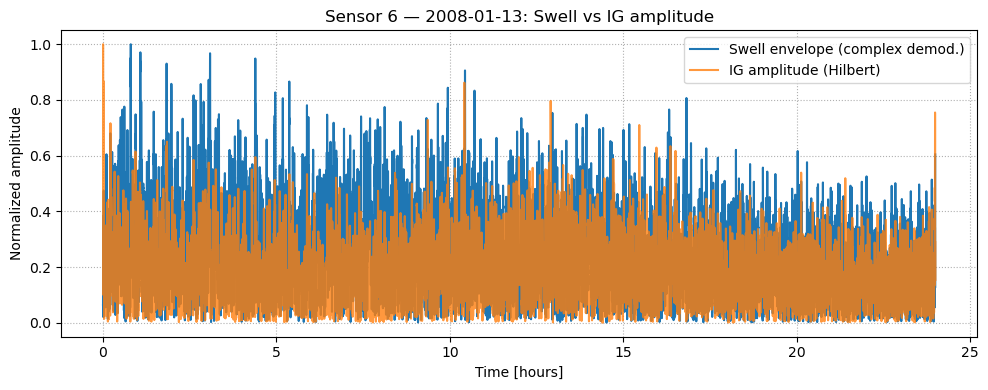

In [130]:
from scipy.signal import hilbert

# IG bandpass (tweak if needed)
fmin_ig, fmax_ig = 0.004, 0.04  # ~250–25 s
b_ig, a_ig = butter(4, [fmin_ig/(fs/2), fmax_ig/(fs/2)], btype="band")
p_ig = filtfilt(b_ig, a_ig, p_detr)

# IG amplitude envelope using Hilbert
A_ig = np.abs(hilbert(p_ig))

# normalize both for plotting on same scale
A_swell_n = A_swell / np.max(A_swell)
A_ig_n    = A_ig    / np.max(A_ig)

plt.figure(figsize=(10,4))
plt.plot(t_sec/3600, A_swell_n, label="Swell envelope (complex demod.)")
plt.plot(t_sec/3600, A_ig_n,    label="IG amplitude (Hilbert)", alpha=0.8)
plt.xlabel("Time [hours]")
plt.ylabel("Normalized amplitude")
plt.title("Sensor 6 — 2008-01-13: Swell vs IG amplitude")
plt.grid(True, ls=":")
plt.legend()
plt.tight_layout()
plt.show()


In [131]:
print("12-25: mean A_swell, A_ig =", A_swell_1225.mean(), A_ig_1225.mean())
print("01-13: mean A_swell, A_ig =", A_swell_0113.mean(), A_ig_0113.mean())

NameError: name 'A_swell_1225' is not defined